# Launch Delay Model

Brian M. Gardner <bgardne1@stevens.edu>

Paul T. Grogan <pgrogan@stevens.edu>

## Introduction

This script performs statistical analysis and probabilistic modeling for launch delays using a [pre-processed data set](LaunchDelayDaya.ipynb).

Most of the required imports below are standard on typical Python 3 distributions; however, you may have to install tabulate separately (`!pip install tabulate`).

In [12]:
from IPython.display import HTML, display
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize, stats
from datetime import datetime, timedelta

## Data Set

The data set includes lead times (time before planned launch) and delay times (time between planned and actual launches). Please see the [corresponding data notebook](LaunchDelayDaya.ipynb) for the source.

In [13]:
lead = np.array([108, 156, 71, 244, 131, 17, 273, 170, 144, 61, 23, 321, 230, 145, 119, 89, 38, 390, 257, 295, 205, 157, 84, 48, 8, 515, 382, 323, 233, 204, 108, 94, 22, 426, 376, 263, 196, 193, 169, 107, 71, 42, 508, 376, 443, 353, 312, 239, 163, 110, 67, 26, 509, 500, 387, 332, 291, 294, 163, 151, 115, 67, 8, 633, 285, 506, 612, 375, 302, 226, 216, 180, 132, 121, 47, 783, 650, 624, 534, 493, 420, 344, 345, 309, 261, 187, 113, 595, 462, 349, 259, 218, 145, 284, 213, 177, 326, 252, 178, 689, 921, 540, 450, 409, 285, 260, 272, 236, 188, 117, 237, 1032, 899, 901, 811, 770, 697, 621, 638, 602, 554, 480, 496, 873, 740, 702, 612, 206, 133, 422, 514, 370, 342, 268, 194, 998, 865, 1213, 757, 716, 643, 567, 586, 484, 436, 362, 288, 817, 684, 737, 647, 606, 533, 457, 471, 413, 382, 308, 404, 19, 960, 827, 936, 846, 805, 732, 656, 585, 549, 768, 694, 620, 80, 1148, 1025, 947, 857, 816, 743, 667, 704, 550, 502, 428, 358, 52, 16])

delay = np.array([25, 47, -1, 19, -1, 0, 149, 119, 32, 25, 22, 200, 158, 130, 66, 55, 33, 217, 217, 66, 66, 73, 73, 33, 2, 108, 108, 54, 54, 42, 65, 3, 4, 251, 168, 168, 145, 107, 58, 44, 9, 2, 206, 205, 25, 25, 25, 25, 25, 7, 14, 7, 279, 155, 155, 120, 120, 44, 99, 40, 40, 40, 25, 249, 464, 130, -66, 130, 130, 130, 69, 69, 69, 6, 6, 174, 174, 87, 87, 87, 87, 87, 15, 15, 15, 15, 15, 414, 414, 414, 414, 414, 414, 199, 199, 199, 2, 2, 2, 429, 64, 332, 332, 332, 383, 332, 249, 249, 249, 246, 52, 194, 194, 79, 79, 79, 79, 79, -9, -9, -9, -9, -99, 369, 369, 294, 294, 659, 659, 294, 131, 239, 219, 219, 219, 345, 345, -116, 250, 250, 250, 250, 160, 226, 226, 226, 226, 617, 617, 451, 451, 451, 451, 451, 366, 388, 371, 371, 201, 8, 527, 527, 305, 305, 305, 305, 305, 305, 305, 38, 38, 38, 0, 411, 401, 366, 366, 366, 366, 366, 258, 376, 376, 376, 372, 100, 14])

The analysis splits the data into three planning horizons:
 * Near-term: lead time between 0 and 90 days.
 * Intermediate: lead time between 90 and 180 days.
 * Long-term: lead time between 180 and 360 days.
 
Descriptive statistics characterize the lead and delay times.

In [14]:
lead_90 = lead[lead <= 90]
delay_90 = delay[lead <= 90]
lead_180 = lead[np.logical_and(lead > 90, lead <= 180)]
delay_180 = delay[np.logical_and(lead > 90, lead <= 180)]
lead_360 = lead[np.logical_and(lead > 180, lead <= 360)]
delay_360 = delay[np.logical_and(lead > 180, lead <= 360)]

display(HTML(tabulate([
    ["Lead Time ($t$, days)", "Near-term", "Intermediate", "Long-term"],
    ["Count", f"{np.size(lead_90):.0f}", f"{np.size(lead_180):.0f}", f"{np.size(lead_360):.0f}"],
    ["Minimum", f"{np.min(lead_90):.0f}", f"{np.min(lead_180):.0f}", f"{np.min(lead_360):.0f}"],
    ["Maximum", f"{np.max(lead_90):.0f}", f"{np.max(lead_180):.0f}", f"{np.max(lead_360):.0f}"],
    ["Mean", f"{np.mean(lead_90):.1f}", f"{np.mean(lead_180):.1f}", f"{np.mean(lead_360):.1f}"],
    ["Std. Dev.", f"{np.std(lead_90, ddof=1):.1f}", f"{np.std(lead_180, ddof=1):.1f}", f"{np.std(lead_360, ddof=1):.1f}"]
], tablefmt='html')))

display(HTML(tabulate([
    ["Delay Time ($t$, days)", "Near-term", "Intermediate", "Long-term"],
    ["Count (Zero, %)", 
     f"{np.size(delay_90):.0f} ({np.sum(delay_90<=0):.0f}, {np.sum(delay_90<=0)/np.size(delay_90):.1%})", 
     f"{np.size(delay_180):.0f} ({np.sum(delay_180<=0):.0f}, {np.sum(delay_180<=0)/np.size(delay_180):.1%})", 
     f"{np.size(delay_360):.0f} ({np.sum(delay_360<=0):.0f}, {np.sum(delay_360<=0)/np.size(delay_360):.1%})"],
    ["Minimum", f"{np.min(delay_90):.0f}", f"{np.min(delay_180):.0f}", f"{np.min(delay_360):.0f}"],
    ["Maximum", f"{np.max(delay_90):.0f}", f"{np.max(delay_180):.0f}", f"{np.max(delay_360):.0f}"],
    ["Mean", f"{np.mean(delay_90):.1f}", f"{np.mean(delay_180):.1f}", f"{np.mean(delay_360):.1f}"],
    ["Std. Dev.", f"{np.std(delay_90, ddof=1):.1f}", f"{np.std(delay_180, ddof=1):.1f}", f"{np.std(delay_360, ddof=1):.1f}"]
], tablefmt='html')))

"Lead Time ($t$, days)",Near-term,Intermediate,Long-term
Count,21,26,48
Minimum,8,94,187
Maximum,89,180,358
Mean,45.5,138.7,268.2
Std. Dev.,26.3,26.0,50.5


"Delay Time ($t$, days)",Near-term,Intermediate,Long-term
"Count (Zero, %)","21 (3, 14.3%)","26 (1, 3.8%)","48 (0, 0.0%)"
Minimum,-1,-1,2
Maximum,100,659,659
Mean,22.4,98.1,170.6
Std. Dev.,26.4,146.0,149.8


A scatter plot shows generally increasing delay time with increasing planning lead time.

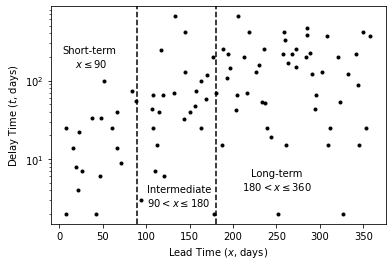

In [15]:
plt.figure()
plt.semilogy(lead[lead<=360], delay[lead<=360], '.k')
plt.annotate('Short-term\n $x\leq 90$', (35,150), ha='center', rotation=0)
plt.axvline(x=90, ls='--', c='k')
plt.annotate('Intermediate\n$90 <x \leq 180$', (138,2.5), ha='center', rotation=0)
plt.axvline(x=180, ls='--', c='k')
plt.annotate('Long-term\n$180 <x\leq 360$', (250,4), ha='center', rotation=0)
plt.xlabel('Lead Time ($x$, days)')
plt.ylabel('Delay Time ($t$, days)')
plt.show()

And a cumulative distribution function (CDF) compares the delay distribution for the three planning horizons.

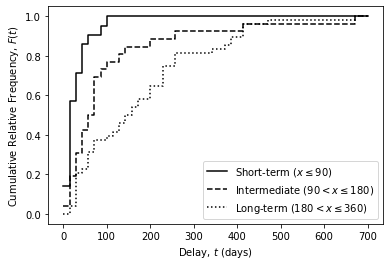

In [16]:
plt.figure()
t = np.linspace(0, np.round(np.max(delay), -2))
plt.step(t, [np.sum(delay_90 <= i)/np.size(delay_90) for i in t], '-k', where='post', label='Short-term ($x\leq 90$)')
plt.step(t, [np.sum(delay_180 <= i)/np.size(delay_180) for i in t], '--k', where='post', label='Intermediate ($90 < x \leq 180$)')
plt.step(t, [np.sum(delay_360 <= i)/np.size(delay_360) for i in t], ':k', where='post', label='Long-term ($180 < x \leq 360$)')
plt.xlabel('Delay, $t$ (days)')
plt.ylabel('Cumulative Relative Frequency, $F(t)$')
plt.legend()
plt.show()

## Maximum Likelihood Estimation

This model uses a hybrid Weibull distribution with a probability mass $p_0$ for zero delay and a probability density for positive delay based on the scale factor $\alpha$ and shape factor $\gamma$. The probability density function (PDF) $f(t)$ and cumulative distribution function (CDF) $F(t)$ resemble a standard Weibull distribution.
$$
f(t) = \left(1-p_0\right)\frac{\gamma}{\alpha} \left(\frac{t}{\alpha}\right)^{\gamma-1}e^{-\left(t/\alpha\right)^\gamma}, \quad t>0
$$
$$
F(t) =  p_0 + \left(1-p_0\right) \left( 1-e^{-\left(t/\alpha\right)^\gamma}\right), \quad t \geq 0
$$

Maximum likelihood estimation (MLE) is a statistical inference procedure to fit model parameters using observed data. This method seeks to maximize the likelihood function (transformed using a logarithm for numerical efficiency) or, equivalently, minimize the minus log likelihood function.

The log likelihood function for the hybrid Weibull distribution is given as
$$
\log L\left(\lbrace t_i \rbrace, \gamma, \alpha\right) = \begin{cases}
        \sum_{t_i} \log\left(f(t_i)\right) & N_0 = 0 \\
        N_0\log\left(p_0\right) + \sum_{t_i>0} \log\left(f(t_i)\right) & N_0 > 0
    \end{cases} 
$$
where $N_0$ is the number of zero-delay observations, $N$ is the number of positive delay observations and $p_0=N_0/(N_0+N)$.


In [17]:
def hybrid_weibull_pdf(t, p_0, shape, scale):
    """
    Computes the probability density function (PDF) for a hybrid Weibull distribution.
    
    Args:
        t (float): delay (days)
        p_0 (float): probability mass for zero delay
        shape: shape parameter (γ)
        scale: scale parameter (α)
    
    Returns:
        float: the probability density
    """
    return (1-p_0)*stats.weibull_min.pdf(t, shape, loc=0, scale=scale)

def hybrid_weibull_cdf(t, p_0, shape, scale):
    """
    Computes the cumulative distribution function (CDF) for a hybrid Weibull distribution.
    
    Args:
        t (float): delay (days)
        p_0 (float): probability mass for zero delay
        shape: shape parameter (γ)
        scale: scale parameter (α)
    
    Returns:
        float: the probability density
    """
    return p_0*(t>=0) + (1-p_0)*stats.weibull_min.cdf(t, shape, loc=0, scale=scale)
    
def minus_log_likelihood_hybrid_weibull(params, obs):
    """
    Compute the minus log likelihood function for a hybrid Weibull distribution.
    
    Args:
        params (:obj:`tuple`): The Weibull distribution parameters (shape, scale).
        obs (:obj:`list`): The list of flight delay observations.
    
    Returns:
        float: the minus log likelihood value.
    """
    # determine the number of zero-delay launches
    N_0 = np.sum(obs<=0)
    # compute the probability mass for zero-delay
    p_0 = N_0/np.size(obs)
    # compute the probability density for each positive delay
    p_i = hybrid_weibull_pdf(obs[obs>0], p_0, params[0], params[1])
    if np.any(p_i == 0):
        # if any probability densities are zero, return an infinite value
        return np.inf
    elif N_0 > 0:
        # if there are any zero-delay launches, return the hybrid minus log likelihood
        return -N_0*np.log(p_0) - np.sum(np.log(p_i))
    else:
        # otherwise, return the simple minus log likelihood
        return -np.sum(np.log(p_i))

The maximum likelihood method uses numerical optimization methods to minimize the minus log likelihood function.

In [18]:
def mle_hybrid_weibull(obs, params_0, bounds=None):
    """
    Maximize the log likehood value for a hybrid Weibull distribution.
    
    Args:
        obs (:obj:`list`): The list of flight delay observations.
        params_0 (:obj:`tuple`): The initial value of Weibull distribution parameters (shape, scale).
        bounds (:obj:`tuple`, optional): The bounds for Weibull distribution parameters (shape, scale).
    
    Returns:
        (float, :obj:`tuple`): the probability mass (p_0) and distribution parameters (shape, scale).
    """
    # determine the number of zero-delay launches
    N_0 = np.sum(obs<=0)
    # compute the probability mass for zero-delay
    p_0 = N_0/np.size(obs)
    # minimize the minus log likelihood function
    res = optimize.minimize(minus_log_likelihood_hybrid_weibull, params_0, obs, method='SLSQP', bounds=bounds)
    # return the probability mass and distribution parameters
    return (p_0, res)

Finally, MLE is performed for each of the three planning horizons.

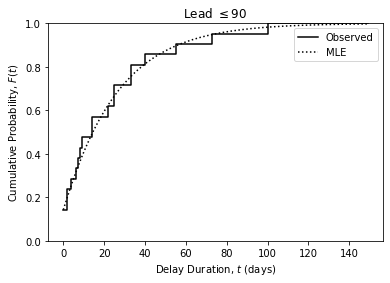

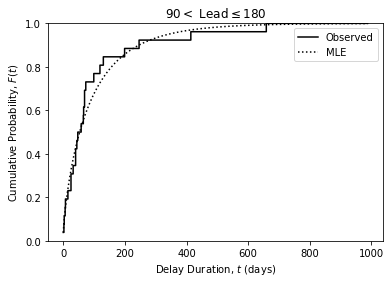

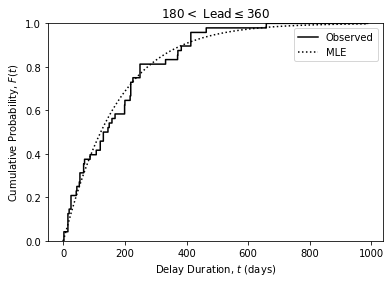

Horizon,Log Likelihood,Zero-delay p_0,Shape (γ),Scale (α)
Near-term,-85.40,14.3%,1.02,26.5
Intermediate,-143.76,3.8%,0.81,89.7
Long-term,-294.63,0.0%,1.04,172.9


In [27]:
LL = np.zeros(3)
p_0_mle = np.zeros(3)
shape_mle = np.zeros(3)
scale_mle = np.zeros(3)

labels = ['Lead $\leq 90$', '$90 <$ Lead$ \leq 180$', '$180 <$ Lead$ \leq 360$']

for ii, obs in enumerate([delay_90, delay_180, delay_360]):
    p_0_mle[ii], res = mle_hybrid_weibull(obs, (1, 30))
    shape_mle[ii] = res.x[0]
    scale_mle[ii] = res.x[1]
    LL[ii] = -minus_log_likelihood_hybrid_weibull(res.x, obs)
    
    plt.figure()
    t = np.arange(0,np.max(obs)*1.5)
    plt.title(labels[ii])
    plt.step(t, [np.sum(obs <= i)/np.size(obs) for i in t], '-k', where='post', label='Observed')
    plt.plot(t, hybrid_weibull_cdf(t, p_0_mle[ii], shape_mle[ii], scale_mle[ii]), ':k', label='MLE')
    plt.xlabel('Delay Duration, $t$ (days)')
    plt.ylabel('Cumulative Probability, $F(t)$')
    plt.ylim([0,1])
    plt.legend(loc='best')
    plt.show()

display(HTML(tabulate([
    ["Horizon", "Log Likelihood", "Zero-delay p_0", "Shape (γ)", "Scale (α)"],
    ["Near-term", f"{LL[0]:.2f}", f"{p_0_mle[0]:.1%}", f"{shape_mle[0]:.2f}", f"{scale_mle[0]:.1f}"],
    ["Intermediate", f"{LL[1]:.2f}", f"{p_0_mle[1]:.1%}", f"{shape_mle[1]:.2f}", f"{scale_mle[1]:.1f}"],
    ["Long-term", f"{LL[2]:.2f}", f"{p_0_mle[2]:.1%}", f"{shape_mle[2]:.2f}", f"{scale_mle[2]:.1f}"]
], tablefmt='html')))

## Bootstrapping Analysis

Bootstrapping analysis performs repeated MLE samples by resampling (with replacement) from the source data set. It can help understand how model parameters are affected by small sample sizes.

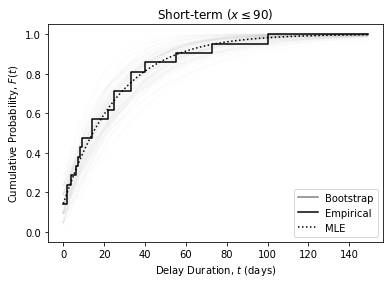

Short-term,Mean,95% CI (Lower),95% CI (Upper)
Zero Delay (p_0),14.3%,4.8%,24.0%
Shape (γ),1.02,0.87,1.49
Scale (α),26.5,17.7,41.2


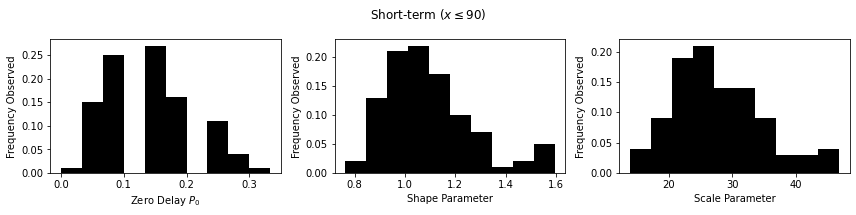

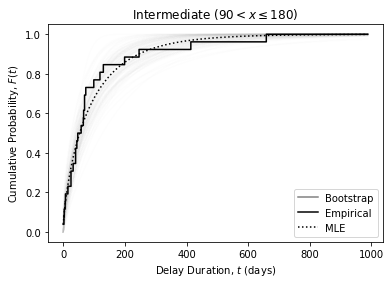

Intermediate,Mean,95% CI (Lower),95% CI (Upper)
Zero Delay (p_0),3.8%,0.0%,11.5%
Shape (γ),0.81,0.69,1.18
Scale (α),89.7,57.2,131.3


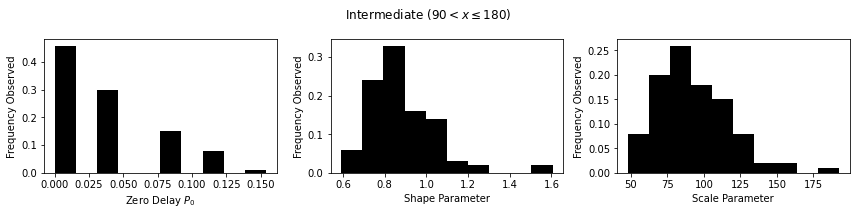

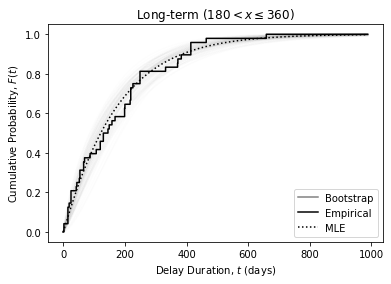

Long-term,Mean,95% CI (Lower),95% CI (Upper)
Zero Delay (p_0),0.0%,0.0%,0.0%
Shape (γ),1.04,0.88,1.28
Scale (α),172.9,137.6,222.6


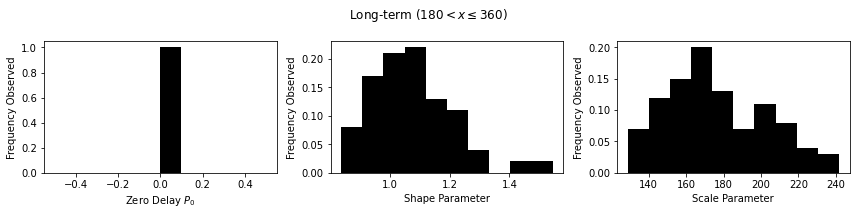

In [20]:
N_SAMPLES = 100
p_0_mean = np.zeros(3)
shape_mean = np.zeros(3)
scale_mean = np.zeros(3)

table_labels = ['Short-term', 'Intermediate', 'Long-term']
labels = ['Short-term ($x\leq 90$)', 'Intermediate ($90 < x \leq 180$)', 'Long-term ($180 < x\leq 360$)']

for ii, obs in enumerate([delay_90, delay_180, delay_360]):
    p_0 = np.zeros(N_SAMPLES)
    shape = np.zeros(N_SAMPLES)
    scale = np.zeros(N_SAMPLES)
    
    np.random.seed(0)
    
    for i in range(N_SAMPLES):
        obs_bootstrap = np.random.choice(obs, size=len(obs), replace=True)
        p_0[i], res = mle_hybrid_weibull(obs_bootstrap, (1, 30))
        shape[i] = res.x[0]
        scale[i] = res.x[1]
    
    t = np.arange(0,np.max(obs)*1.5)
    p, res = mle_hybrid_weibull(obs, (1, 30))
    p_0_mean[ii] = p
    shape_mean[ii] = res.x[0]
    scale_mean[ii] = res.x[1]
    
    plt.figure()
    for i in range(N_SAMPLES):
        F_t = p_0[i] + (1-p_0[i])*stats.weibull_min.cdf(t, shape[i], scale=scale[i])
        plt.plot(t, F_t, '-', color='grey', alpha=0.01, label='Bootstrap' if i == 0 else None)
    plt.step(t, [np.sum(obs <= i)/np.size(obs) for i in t], '-k', where='post', label='Empirical')
    plt.plot(t, p + (1-p)*stats.weibull_min.cdf(t, res.x[0], scale=res.x[1]), ':k', label='MLE')
    plt.xlabel('Delay Duration, $t$ (days)')
    plt.ylabel('Cumulative Probability, $F(t)$')
    plt.title(labels[ii])
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.show()
    
    display(HTML(tabulate([
        [table_labels[ii], "Mean", "95% CI (Lower)", "95% CI (Upper)"],
        ["Zero Delay (p_0)", f"{p_0_mean[ii]:.1%}", f"{np.percentile(p_0, 5):.1%}", f"{np.percentile(p_0, 95):.1%}"],
        ["Shape (γ)", f"{shape_mean[ii]:.2f}", f"{np.percentile(shape, 5):.2f}", f"{np.percentile(shape, 95):.2f}"],
        ["Scale (α)", f"{scale_mean[ii]:.1f}", f"{np.percentile(scale, 5):.1f}", f"{np.percentile(scale, 95):.1f}"]
    ], tablefmt='html')))
    
    fig, axes = plt.subplots(1,3,figsize=(12,3))
    axes[0].hist(p_0, weights=np.ones_like(p_0)/np.size(p_0), color='k')
    axes[0].set_xlabel('Zero Delay $P_0$')
    axes[0].set_ylabel('Frequency Observed')
    axes[1].hist(shape, weights=np.ones_like(shape)/np.size(shape), color='k')
    axes[1].set_xlabel('Shape Parameter')
    axes[1].set_ylabel('Frequency Observed')
    axes[2].hist(scale, weights=np.ones_like(scale)/np.size(scale), color='k')
    axes[2].set_xlabel('Scale Parameter')
    axes[2].set_ylabel('Frequency Observed')
    plt.suptitle(labels[ii])
    plt.tight_layout()
    plt.show()

## Quantization (Lloyd-Max Algorithm)

The Lloyd-Max algorithm can be used to convert the continuous distribution to a discrete distribution suitable for decision trees or other probabilistic scenario analysis. The method assumes $n$ quantization regions for discrete delays between $T_{min}$ and $T_{max}$ values. For example, one may start with evenly-spaced representation points $a_i$:
$$
a_i = T_{min} + \frac{ (T_{max}-T_{min})}{n} \cdot\frac{(2i-1)}{2}, \;\; 1\leq i \leq n
$$

Quantization region endpoints $b_i$ are defined by:
$$
b_i = \begin{cases} T_{min} & \mbox{if }i=0 \\ \frac{1}{2}\left(a_i+a_{i+1}\right) & \mbox{if } 0 < i < n \\ T_{max} & \mbox{if }i=n \end{cases}
$$

For a set of quantization regions ($a_i$) and region endpoints ($b_i$), the mean square error (MSE) is given by:
$$
MSE = \sum_{i=1}^{n} \int_{b_{i-1}}^{b_i} f(t)\cdot \left(t-a_i\right)^2 \, dt
$$
and updated representation points are computed by:
$$
a_i = \frac{\int_{b_{i-1}}^{b_i} t \cdot f(t) \,  dt}{\int_{b_{i-1}}^{b_i} f(t) \, dt}
$$

The Lloyd-Max algorithm improves MSE by iteratively updating representation points until reaching a specfied convergence threshold.

The associated probability mass of each quantization region is found by integrating the continuous function:
$$
p(a_i) = \int_{b_{i-1}}^{b_i} f(t) \, dt
$$


Iteration,MSE,$a_1$ ($p(a_1)$),$a_2$ ($p(a_2)$),$a_3$ ($p(a_3)$),$a_4$ ($p(a_4)$),$a_5$ ($p(a_5)$),$a_6$ ($p(a_6)$)
0,59.9,14.3 (0.566),42.9 (0.195),71.4 (0.064),100.0 (0.021),128.6 (0.007),157.2 (0.002)
1,51.7,11.9 (0.537),40.3 (0.214),68.8 (0.071),97.4 (0.023),126.0 (0.007),154.5 (0.003)
2,47.2,11.1 (0.516),37.8 (0.224),66.2 (0.079),94.8 (0.026),123.3 (0.008),152.7 (0.003)


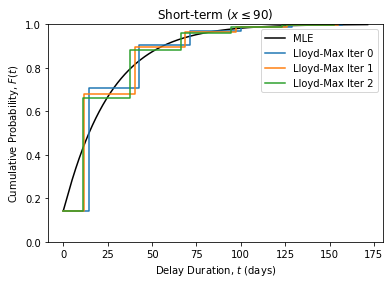

In [30]:
def lloyd_max_hybrid_weibull(a, t_min, t_max, p_0, shape, scale):
    # compute the interval bounds as the midpoints between each a, bounded by t_min and t_max
    b = np.array(
        [t_min] + [
            (a[i]+a[i+1])/2 
            for i in range(len(a)-1)
        ] + [t_max]
    )
    
    # compute the equivalent probability mass function by numerically integrating the PDF over each interval
    p_a = np.array([
        integrate.quad(hybrid_weibull_pdf, b[i], b[i+1], args=(p_0, shape, scale))[0] 
        for i in range(len(a))
    ])
    
    # define a helper function to compute the mean square error
    def mse_fun(t, a, p_0, shape, scale):
        return (t-a)**2*hybrid_weibull_pdf(t, p_0, shape, scale)
    
    # compute the mean square error between the PDF and derived PMF
    mse = np.sum([
        integrate.quad(mse_fun, b[i], b[i+1], args=(a[i],p_0, shape, scale))[0] 
        for i in range(len(a))
    ])
    
    # define a helper function to compute the numerator of the expected value
    def num_fun(t, p_0, shape, scale):
        return t*hybrid_weibull_pdf(t, p_0, shape, scale)
    
    # compute the next values of a using the expected value for each region
    next_a = np.array([
        integrate.quad(num_fun, b[i], b[i+1], args=(p_0, shape, scale))[0] 
        / integrate.quad(hybrid_weibull_pdf, b[i], b[i+1], args=(p_0, shape, scale))[0] 
        for i in range(len(a))
    ])
    
    return b, p_a, mse, next_a

# define minimum and maximum delay values
t_min = 0
t_max = stats.weibull_min.ppf((0.999-p_0_mle[0])/(1-p_0_mle[0]), shape_mle[0], loc=0, scale=scale_mle[0])

# define number of quantization regions and compute initial representation points
n = 6
a_0 = [t_min + (t_max-t_min)/n*(2*i+1)/2 for i in range(n)]

# perform three iterations
b_0, p_a_0, mse_0, a_1 = lloyd_max_hybrid_weibull(a_0, t_min, t_max, p_0_mle[0], shape_mle[0], scale_mle[0])
b_1, p_a_1, mse_1, a_2 = lloyd_max_hybrid_weibull(a_1, t_min, t_max, p_0_mle[0], shape_mle[0], scale_mle[0])
b_2, p_a_2, mse_2, a_3 = lloyd_max_hybrid_weibull(a_2, t_min, t_max, p_0_mle[0], shape_mle[0], scale_mle[0])

display(HTML(tabulate([
    ["Iteration", "MSE", "$a_1$ ($p(a_1)$)", "$a_2$ ($p(a_2)$)", "$a_3$ ($p(a_3)$)", "$a_4$ ($p(a_4)$)", "$a_5$ ($p(a_5)$)", "$a_6$ ($p(a_6)$)"],
    [0, f"{mse_0:.1f}", f"{a_0[0]:.1f} ({p_a_0[0]:.3f})", f"{a_0[1]:.1f} ({p_a_0[1]:.3f})", f"{a_0[2]:.1f} ({p_a_0[2]:.3f})", f"{a_0[3]:.1f} ({p_a_0[3]:.3f})", f"{a_0[4]:.1f} ({p_a_0[4]:.3f})", f"{a_0[5]:.1f} ({p_a_0[5]:.3f})"],
    [1, f"{mse_1:.1f}", f"{a_1[0]:.1f} ({p_a_1[0]:.3f})", f"{a_1[1]:.1f} ({p_a_1[1]:.3f})", f"{a_1[2]:.1f} ({p_a_1[2]:.3f})", f"{a_1[3]:.1f} ({p_a_1[3]:.3f})", f"{a_1[4]:.1f} ({p_a_1[4]:.3f})", f"{a_1[5]:.1f} ({p_a_1[5]:.3f})"],
    [2, f"{mse_2:.1f}", f"{a_2[0]:.1f} ({p_a_2[0]:.3f})", f"{a_2[1]:.1f} ({p_a_2[1]:.3f})", f"{a_2[2]:.1f} ({p_a_2[2]:.3f})", f"{a_2[3]:.1f} ({p_a_2[3]:.3f})", f"{a_2[4]:.1f} ({p_a_2[4]:.3f})", f"{a_2[5]:.1f} ({p_a_2[5]:.3f})"]
 ], tablefmt='html')))

t = np.linspace(t_min, t_max, 1000)
plt.figure()
plt.plot(t, hybrid_weibull_cdf(t, p_0_mle[0], shape_mle[0], scale_mle[0]), 'k', label='MLE')
plt.step(np.append([0], a_0), np.cumsum(np.append(p_0_mle[0], p_a_0)), where='post', label='Lloyd-Max Iter 0')
plt.step(np.append([0], a_1), np.cumsum(np.append(p_0_mle[0], p_a_1)), where='post', label='Lloyd-Max Iter 1')
plt.step(np.append([0], a_2), np.cumsum(np.append(p_0_mle[0], p_a_2)), where='post', label='Lloyd-Max Iter 2')
plt.xlabel('Delay Duration, $t$ (days)')
plt.ylabel('Cumulative Probability, $F(t)$')
plt.ylim([0,1])
plt.legend(loc='best')
plt.title('Short-term ($x\leq 90$)')
plt.show()

In [33]:
# array to record number of iterations, representation points, and probability masses
num_iter = np.zeros(3)
a = np.zeros((3, n))
p_a = np.zeros((3, n))
t_max = np.zeros(3)

# convergence criteria
delta_mse = 1e-2

for ii, horizon in enumerate(['Near-term', 'Intermediate', 'Long-term']):
    t_min = 0
    t_max[ii] = stats.weibull_min.ppf((0.999-p_0_mle[ii])/(1-p_0_mle[ii]), shape_mle[ii], loc=0, scale=scale_mle[ii])

    a[ii,:] = [t_min + (t_max[ii]-t_min)/n*(2*i+1)/2 for i in range(n)]
    prev_mse = mse = None
    while prev_mse is None or mse is None or prev_mse-mse > delta_mse:
        prev_mse = mse
        num_iter[ii]+=1
        b, p_a[ii,:], mse, a[ii,:] = lloyd_max_hybrid_weibull(a[ii,:], t_min, t_max[ii], p_0_mle[ii], shape_mle[ii], scale_mle[ii])

display(HTML(tabulate(
    [
        ["Quantity", "Short-term", "Intermediate", "Long-term"],
        ["$T_{max}$", f"{t_max[0]:.0f}", f"{t_max[1]:.0f}", f"{t_max[2]:.0f}"],
        ["Iterations", f"{num_iter[0]:.0f}", f"{num_iter[1]:.0f}", f"{num_iter[2]:.0f}"],
        ["$i$", "$a_i$  ($p(a_i)$)", "$a_i$ ($p(a_i)$)", "$a_i$ ($p(a_i)$)"]
    ] + [
        [i+1, f"{a[0,i]:.1f} ({p_a[0,i]:.3f})", f"{a[1,i]:.1f} ({p_a[1,i]:.3f})", f"{a[2,i]:.1f} ({p_a[2,i]:.3f})"]
        for i in range(n)
    ], tablefmt='html'
)))

Quantity,Short-term,Intermediate,Long-term
$T_{max}$,171,965,1114
Iterations,66,92,97
$i$,$a_i$ ($p(a_i)$),$a_i$ ($p(a_i)$),$a_i$ ($p(a_i)$)
1,5.8 (0.319),20.3 (0.453),38.0 (0.364)
2,19.2 (0.231),82.7 (0.246),123.1 (0.270)
3,35.1 (0.154),164.8 (0.141),224.2 (0.182)
4,54.9 (0.092),274.5 (0.075),350.5 (0.110)
5,81.5 (0.045),429.9 (0.034),520.4 (0.055)
6,122.5 (0.015),679.1 (0.011),784.3 (0.018)
